## Assessing Accuracy

#### Set Up Script

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Root directory of MRCNN
MASK_RCNN_DIR = os.path.abspath("../../Mask_RCNN/")

# Import Mask RCNN
sys.path.append(MASK_RCNN_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import oyster

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


## Configurations

In [2]:
config = oyster.OysterConfig()
OYSTER_DIR = "../data/2kx2k_dataset/"

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.02
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 2.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Load Dataset

In [6]:
# Load validation dataset
dataset_test = oyster.OysterDataset()
dataset_test.load_oyster(OYSTER_DIR, "test")

# Must call before using the dataset
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

Images: 66
Classes: ['BG', 'oyster']


### Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
# Set path to oyster weights file
weights_path = '../data/models/2kx2k_model.h5'

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  /host/Code/Mask_RCNN/logs/oyster20190109T1451/mask_rcnn_oyster_0180.h5
Re-starting from epoch 180


In [8]:
def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
        
    # If either set of masks is empty return empty result
    if masks2.shape[-1] == 0:
        overlaps = 0
        intersections = 0
        area2 = 0
        masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
        area1 = np.sum(masks1, axis=0)
        union = area2
        return(overlaps, intersections, union, area1, area2)
    if masks1.shape[-1] == 0:
        return(-1)
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return(overlaps, intersections, union, area1, area2)

def calculate_metrics(dataset, prediction_threshold=0.5):
    total_gt = 0  # total ground truth reefs
    total_predicted = 0 # total predicted reefs
    total_tp = 0 # total true positives
    total_fp = 0 # total false positives
    total_px = 0 # all pixels
    total_fn = 0

    for image_id in dataset.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        
        # filter out masks that don't meet a prediction threshold
        r['masks'] = np.array(r['masks'][:,:, r['scores'] > prediction_threshold])

        overlap, intersection, union, gt_area, mask_area = compute_overlaps_masks(gt_mask, r['masks'])
            
        total_tp += np.sum(intersection)
        total_predicted += np.sum(mask_area)
        total_gt += np.sum(gt_mask)

        total_fp += np.sum(mask_area) - np.sum(intersection) 

        total_fn += np.sum(gt_mask) - np.sum(intersection) 

        length, width, instances = gt_mask.shape
        total_px += length * width
        
    total_tn = total_px - total_predicted
    return(total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px)

def calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn):
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    acc = (total_tp + total_tn) / total_px
    return(precision, recall, acc)

In [9]:
total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px = calculate_metrics(dataset_test, prediction_threshold=0.98)
precision, recall, acc = calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn)

In [10]:
total_gt, total_predicted

(4847769, 5230570.0)

In [49]:
pra_list_extd = []
for confidence in np.arange(0.991, 1.000, 0.001):
    total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px = calculate_metrics(dataset_test, prediction_threshold=confidence)
    precision, recall, acc = calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn)
    pra_list_extd.append([precision, recall, acc])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
pra_list = []
for confidence in np.arange(0.0, 1.01, 0.01):
    total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px = calculate_metrics(dataset_test, prediction_threshold=confidence)
    precision, recall, acc = calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn)
    pra_list.append([precision, recall, acc])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


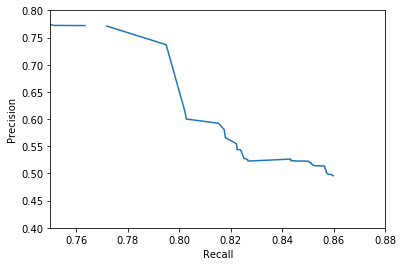

In [50]:
fig, ax = plt.subplots()
pra_array = np.array(pra_list + pra_list_extd)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.75,0.88)
ax.set_ylim(0.4,0.8)
ax.plot([i[1] for i in pra_array], [i[0] for i in pra_array])

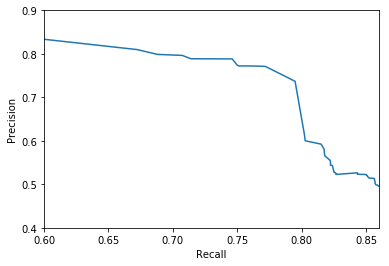

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
pra_array = np.array(pra_list_extd)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.6,.86)
ax.set_ylim(0.4,.9)
ax.plot([i[1] for i in pra_array], [i[0] for i in pra_array])

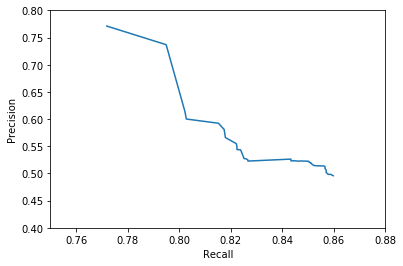

In [35]:
fig, ax = plt.subplots()
pra_array = np.array(pra_list)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.75,0.88)
ax.set_ylim(0.4,0.8)
ax.plot([i[1] for i in pra_array], [i[0] for i in pra_array])

In [295]:
#image_ids = np.random.choice(dataset_test.image_ids, 53)

APs = []
AP_ranges = []
precisions_list = []
recalls_list = []

total_gt = 0  # total ground truth reefs
total_predicted = 0 # total predicted reefs
total_tp = 0 # total true positives

for image_id in dataset_test.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]

    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    """
    AP_range = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'],
                     iou_thresholds=None, verbose=0)
    AP_ranges.append(AP_range)
    """
    gt_match, pred_match, overlaps = utils.compute_matches(gt_bbox, gt_class_id, gt_mask,
                    r["rois"], r["class_ids"], r["scores"], r['masks'],
                    iou_threshold=0.5, score_threshold=0.5)
    
    total_gt += gt_match.shape[0]  # total ground truth reefs
    total_predicted += pred_match.shape[0] # total predicted reefs
    total_tp += (pred_match > -1).sum() # total true positives
    
    break

print("mAP: ", np.mean(APs))

mAP:  1.0


In [38]:
total_gt, total_predicted, total_tp

(262, 373, 167)

In [39]:
total_fp = total_predicted - total_tp
total_fn = total_gt - total_tp

# Precision is defined as the number of true positives over the number of true positives plus the number of false positives.

precision = total_tp / (total_tp + total_fp)

# Recall is defined as the number of true positives over the number of true positives plus the number of false negatives.
recall = total_tp / (total_tp + total_fn )